In [44]:
# Core libraries
import numpy as np
import matplotlib.pyplot as plt

# TensorFlow/Keras for modeling
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam

# Scikit-learn for similarity computation
from sklearn.metrics.pairwise import cosine_similarity

#random
import random

In [8]:
# Encoder: Compresses the image into a lower-dimensional embedding
encoder = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same')
])

# Autoencoder: Combines the encoder and decoder for training
autoencoder = Sequential([
    # Encoder layers
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),

    # Decoder layers
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(1, (3, 3), activation='sigmoid', padding='same')
])

In [9]:
# Load and preprocess data
(x_train, _), (x_test, _) = fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape to (28, 28, 1) since CNN expects 4D input
x_train = x_train.reshape((-1, 28, 28, 1))
x_test = x_test.reshape((-1, 28, 28, 1))

# Compile the autoencoder
autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')

In [10]:
# Train the model
autoencoder.fit(
    x_train, x_train,  # Input = target for autoencoder
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test, x_test)
)


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - loss: 0.3699 - val_loss: 0.2809
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 27s 58ms/step - loss: 0.2775 - val_loss: 0.2756
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 54s 85ms/step - loss: 0.2727 - val_loss: 0.2723
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 40s 85ms/step - loss: 0.2694 - val_loss: 0.2703
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 40s 84ms/step - loss: 0.2673 - val_loss: 0.2688
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 86ms/step - loss: 0.2661 - val_loss: 0.2675
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 40s 86ms/step - loss: 0.2649 - val_loss: 0.2667
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 88ms/step - loss: 0.2634 - val_loss: 0.2655
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 88ms/step - loss: 0.2632 - val_loss: 0.2649
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 42s 89ms/step - loss: 0.2622 - val_loss: 0.2629


In [11]:
# Get embeddings for all training images
encoded_imgs = encoder.predict(x_train)

# Flatten the encoded output to 1D vectors (e.g. from 7x7x16 → 784)
embeddings = encoded_imgs.reshape((encoded_imgs.shape[0], -1))  # shape: (60000, 784)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


In [60]:
def get_similar_items(index, top_pool=50, top_n=5):
    query_vec = embeddings[index].reshape(1, -1)
    similarities = cosine_similarity(query_vec, embeddings)[0]
    
    # Get top 'top_pool' most similar (excluding self)
    top_indices = similarities.argsort()[-(top_pool + 1):-1][::-1]

    # Randomly select 'top_n' from them
    selected_indices = random.sample(list(top_indices), top_n)
    return selected_indices


In [ ]:
def show_recommendations(index, top_n=5):
    similar_indices = get_similar_items(index, top_n)
    
    plt.figure(figsize=(2 * (top_n + 1), 3))
    
    # Show the query image
    plt.subplot(1, top_n + 1, 1)
    plt.imshow(x_train[index].squeeze(), cmap='gray')
    plt.title("Query")
    plt.axis('off')

    # Show recommended images
    for i, rec_index in enumerate(similar_indices):
        plt.subplot(1, top_n + 1, i + 2)
        plt.imshow(x_train[rec_index].squeeze(), cmap='gray')
        plt.title(f"Rec {i+1}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

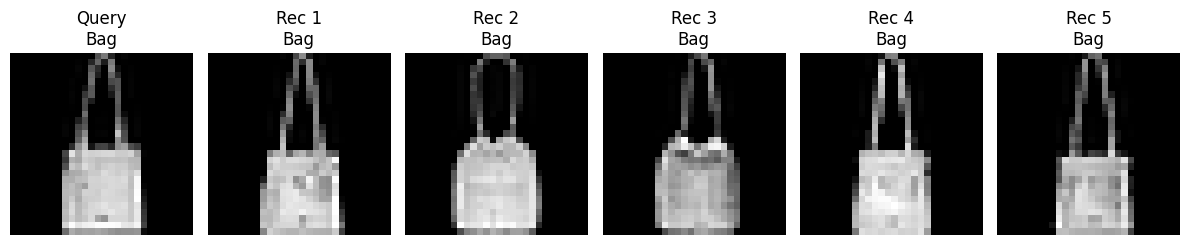

In [ ]:
show_recommendations(200)#Change the index value for different item - show_recommendations(index_value)
#here the grayscale image is used to show the output


For an New User input image in grayscale, sized 28x28

In [83]:
def preprocess_new_image(img):
    img = img.astype('float32') / 255.0  # normalize
    img = img.reshape(1, 28, 28, 1)      # shape for model
    return img

def get_embedding_for_new_image(img):
    processed_img = preprocess_new_image(img)
    encoded = encoder.predict(processed_img)
    return encoded.reshape(1, -1)

def recommend_for_new_image(img, top_n=5):
    query_vec = get_embedding_for_new_image(img)
    similarities = cosine_similarity(query_vec, embeddings)[0]
    top_indices = similarities.argsort()[-(top_n + 1):-1][::-1]

    plt.figure(figsize=(2 * (top_n + 1), 3))
    plt.subplot(1, top_n + 1, 1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title("New Query")
    plt.axis('off')

    for i, idx in enumerate(top_indices):
        plt.subplot(1, top_n + 1, i + 2)
        plt.imshow(x_train[idx].squeeze(), cmap='gray')
        plt.title(f"Rec {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


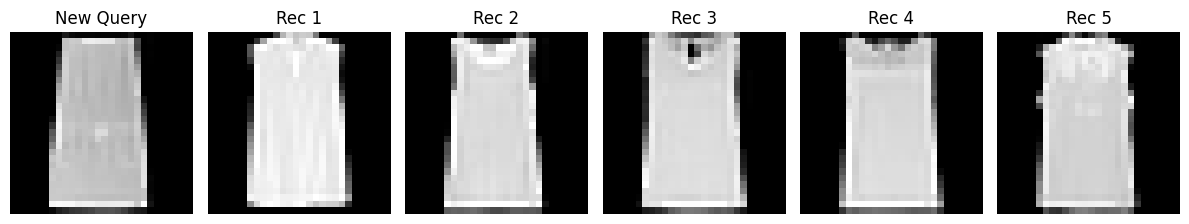

In [84]:
# Use any new 28x28 grayscale image
new_img = x_test[42]  # example; replace with your own input
recommend_for_new_image(new_img)

Recommendation based on Labels

In [76]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

fashion_labels = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

def show_one_per_class():
    plt.figure(figsize=(15, 3))
    for label in range(10):  # from 0 to 9 in order
        # Get first image with this label
        idx = np.where(y_train == label)[0][0]
        plt.subplot(1, 10, label + 1)
        plt.imshow(x_train[idx], cmap='gray')
        plt.title(f"{fashion_labels[label]}\nLabel: {label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    
def get_random_index_for_label(label):
    indices = np.where(y_train == label)[0]
    return random.choice(indices)

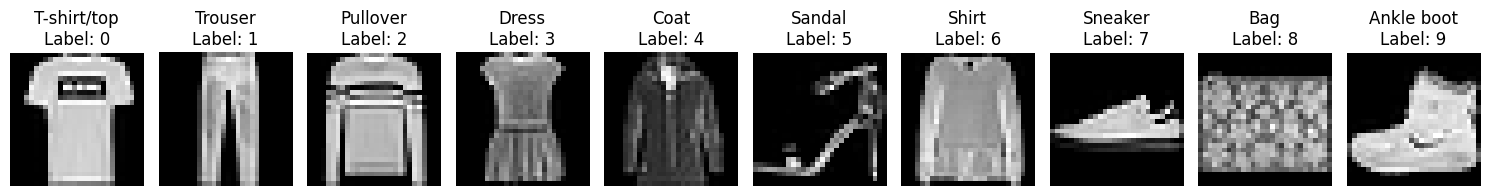

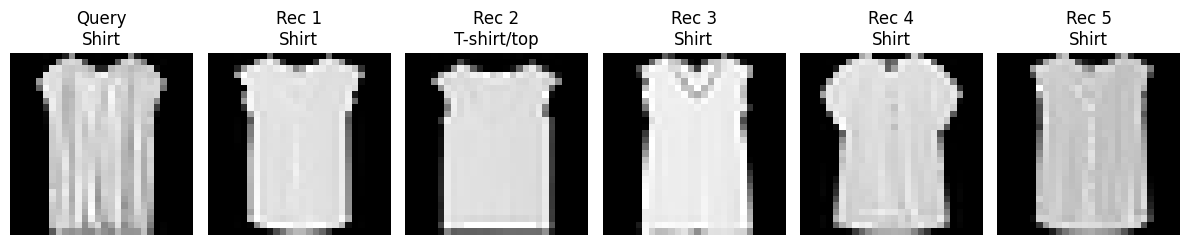

In [77]:
# Show labels visually
show_one_per_class()

# Ask for user input
user_label = int(input("Enter a label (0–9) to get recommendations from that class: "))

# Get a random image index with that label
query_index = get_random_index_for_label(user_label)

# Show recommendations based on that image
show_recommendations(query_index)
